# 文本分类问题
下面我们来看一个文本分类问题，经典的新闻主题分类，用朴素贝叶斯怎么做。

In [1]:
import jieba
seg_list = jieba.cut("他来到东海识别区",cut_all=False)
print("/" .join(seg_list) )
jieba.add_word('东海识别区')
seg_list = jieba.cut("他来到东海识别区",cut_all=False)
print("/ " .join(seg_list) )

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\WINDOWS\TEMP\jieba.cache
Loading model cost 0.718 seconds.
Prefix dict has been built successfully.


他/来到/东海/识别区
他/ 来到/ 东海识别区


In [5]:
#coding: utf-8
import os
import time
import random
import jieba  #处理中文
import nltk  #处理英文
import sklearn
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import nltk

## 文本处理
1、把训练样本划分为训练集和测试集

2、统计了词频，按词频降序生成词袋

In [16]:
# 文本处理，也就是样本生成过程
def text_processing(folder_path, test_size=0.2):
    folder_list = os.listdir(folder_path)
    # os.listdir 方法用于返回路径下包含的文件或文件夹的名字的列表
    # folder_list = ['C000008', 'C000014', 'C000013', 'C000022', 'C000023', 'C000024', 'C000010', 'C000020', 'C000016']
    
    data_list = []
    class_list = []

    # 遍历文件夹，每个文件夹里是一个新闻的类别
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)
        # os.path.join就是把两个路径拼接
        # new_folder_path = ./Database/SogouC/Sample/C000008
        
        files = os.listdir(new_folder_path)
        # 读取new_folder_path路径下的文件名
        # ['15.txt', '14.txt', '16.txt', '17.txt', '13.txt', '12.txt', '10.txt', '11.txt', '19.txt', '18.txt']
        
        # 读取文件
        j = 1
        for file in files:
            if j > 100: 
            # 怕内存爆掉，只取100个样本文件，你可以注释掉取完，
            # 这里每个类别下只有10个样本，没事
                break
            with open(os.path.join(new_folder_path, file),'r',encoding='utf-8') as fp:
                raw = fp.read()
                # read() 返回值为str，每次读取整个文件，将文件所有内容放到一个字符串变量中
                # readline() 返回值为str，每次只读取一行,每行的内容放在一个字符串变量中
                # readlines() 返回值为list，一次读取整个文件，每行的内容放在一个字符串变量中作为列表的一个元素。
            
            ## 是的，随处可见的jieba中文分词
            #jieba.enable_parallel(4) # 开启并行分词模式，参数为并行进程数，不支持windows
            word_cut = jieba.cut(raw, cut_all=False) # 精确模式，返回的结构是一个可迭代的genertor
            word_list = list(word_cut) # genertor转化为list，每个词unicode格式
            jieba.disable_parallel() # 关闭并行分词模式
            
            data_list.append(word_list) #训练集list
            #class_list.append(folder.decode('utf-8')) #类别,str.decode会报错
            class_list.append(folder) #训练集的标签类别
            j += 1

            
            
    ## 下面手动粗暴地划分训练集和测试集
    data_class_list = zip(data_list, class_list) # zip 函数返回一个zip对象
    data_class_list = list(data_class_list) # 需要用list转换成列表
    
    random.shuffle(data_class_list) # shuffle随机打乱样本
    index = in    train_list = data_class_list[index:]
    test_list = data_class_list[:index]
    t(len(data_class_list)*test_size)+1

    train_data_list, train_class_list = zip(*train_list) 
    # 解压缩,文本和类别分开返回的是元组格式，可以在用list转换
    test_data_list, test_class_list = zip(*test_list) 
    #以上划分训练集和测试集其实可以用sklearn自带的部分做
    #train_data_list, test_data_list, train_class_list, test_class_list = \
    #sklearn.model_selection.train_test_split(data_list, class_list, test_size=test_size) 
    
    
   
    # 统计词频放入all_words_dict
    all_words_dict = {}
    for word_list in train_data_list:
        for word in word_list:
            #if all_words_dict.has_key(word):已删除此方法
            if word in all_words_dict:
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1
    # all_words_dict={'\n': 1257, '\u3000': 1986, '有': 175, '江湖': 1,.....}
    # 同样以上有现成的统计词频的API可以调用
    # from collections import Counter 
    # Counter(train_data_list)

    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f:f[1], reverse=True) 
    # 内建函数sorted第一个参数需为list，all_words_dict.items()转化为列表，键和值为元组
    # key函数代表按元组的的词频排序，并降序返回结果
    # all_words_tuple_list = [('，', 3424), ('的', 2527), ('\u3000', 1734), ('。', 1482),.....]
    
    #all_words_list = list(zip(*all_words_tuple_list)[0]) 报错，需要修改
    all_words_list,_ = zip(*all_words_tuple_list) # 解压缩
    all_words_list = list(all_words_list)
    # all_words_list = ['，', '的', '\u3000', '。', '\n', '在', ' ', '、', '了', '“',.....]

    return all_words_list, train_data_list, test_data_list, train_class_list, test_class_list

In [17]:
print ("start")

## 文本预处理
folder_path = './Database/SogouC/Sample'
all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = \
text_processing(folder_path, test_size=0.2)
print(len(all_words_list)) # 9748个不重复单词
print(all_words_list[:100])
print(len(train_data_list)) # 71个训练集样本
print(len(test_data_list))  # 19个测试集样本
print(len(train_class_list))  # 71个训练集标签
print(len(test_class_list))  # 19个测试集标签

start
9814
['，', '的', '\u3000', '。', '\n', ';', '&', 'nbsp', '、', '在', ' ', '“', '”', '了', '是', '和', '\x00', '：', '中国', '有', '我', '也', '就', '上', '对', '为', '将', '中', '都', '要', '而', '他', '公司', '年', '游客', '你', '一个', '—', '与', '旅游', '这', '不', '等', '自己', '到', '月', '说', '可以', '人', '考生', '；', '但', '（', '）', '市场', '多', '(', ')', '日', '3', '时', '从', '个', '会', '5', '进行', '把', '已经', '没有', '还', '时间', '来', '1', '让', '志愿', '新', '０', '并', '.', '北京', '以', '更', '后', '地', '企业', '％', '做', '目前', '很', '成为', '美国', '我们', '《', '》', '这样', '被', '支付', '能', '4', '作战']
71
19
71
19


## 停用词文件去重
这个停用词文件不是很官方，所以需要清洗下

In [23]:
# 粗暴的词去重
def make_word_set(words_file):
    words_set = set() # 集合格式
    with open(words_file, 'r',encoding = 'utf-8') as fp:
        for line in fp.readlines(): # 循环取出每一行
            word = line.strip()
            # line.strip() 当()为空时，默认删除空白符（包括'\n','\r','\t',' ')
            if len(word)>0 and word not in words_set: # 去重
                words_set.add(word)
    return words_set

In [24]:
# 生成stopwords_set
stopwords_file = './stopwords_cn.txt' # 停用词列表文件
stopwords_set = make_word_set(stopwords_file) # 首先停用词去重
print(len(stopwords_set))
print(stopwords_set)

428
{'嘿嘿', '许多', '似的', '怎', '尔', '前者', '哪些', '值此', '别的', '怎么样', '可', '要不', '即', '这会', '不', '已', '哪怕', '针对', '怎么', '格里斯', '譬如', '基于', '那里', '那时', '自从', '谁', '仍', '你', '如何', '只限', '因此', '不论', '再则', '彼时', '上', '除了', '今', '说来', '总之', '最', '那', '咱们', '它', '只怕', '与否', '如是', '自身', '不但', '要是', '那边', '以便', '来自', '以至', '起', '因为', '靠', '才能', '趁着', '以', '大家', '遵照', '并', '如同下', '了', '从', '每', '它们', '这里', '么', '个别', '此处', '我们', '可以', '还是', '随着', '不单', '这个', '乃至', '而', '可见', '要不然', '一', '这', '全部', '至', '和', '毋宁', '着', '不管', '跟', '同', '这般', '为着', '之', '虽然', '后者', '替代', '据', '且', '多会', '任何', '这些', '沿着', '全体', '甚而', '去', '可是', '就是', '除外', '有的', '正值', '向', '什么的', '不尽', '该', '好', '作为', '固然', '您', '不料', '往', '他们', '再', '自己', '哪', '还有', '因之', '是', '根据', '对比', '那儿', '宁可', '小', '如上', '关于', '逐步', '就算', '别人', '之所以', '出来', '不仅仅', '儿', '为何', '以来', '一切', '那个', '由此', '当', '后', '被', '向着', '几', '自', '又', '分别', '遵循', '把', '多少', '何时', '本身', '怎么办', '别处', '此次', '给', '有', '尽管如此', '为', '加以', '各位', '这么', '嘛', '拿', '至于', '本着

## 词袋中选取有代表性的特征词
第一步生成的词袋里有很多通用的、无意义的词语，需要去掉。  
有代表性的词语很大概率是一些对最终类别区分有作用的词语。并且后面这些词语会作为特征作为模型的输入。

In [25]:
def words_dict(all_words_list, deleteN, stopwords_set=set()):
    # 选取特征词
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        # 循环时从第20个开始，也就是舍弃前20个词语
        if n > 1000: # feature_words的维度1000
            break
            
        if not all_words_list[t].isdigit() and \
        all_words_list[t] not in stopwords_set and \
        1<len(all_words_list[t])<5:
        # isdigit() 方法检测字符串是否只由数字组成,返回True和False
        # 满足三个条件：不是数字；不在停用词表；长度2～4
            feature_words.append(all_words_list[t])
            n += 1
    return feature_words 

In [27]:
deleteN = 20 
# 删除前20个词语,可以调整这个数值
# 越靠前的词语出现的越频繁，有可能所有类别中都出现很多次，这类词语是可以去掉的。
feature_words = words_dict(all_words_list, deleteN, stopwords_set)
print(feature_words[:100])

['公司', '游客', '一个', '旅游', '考生', '市场', '进行', '已经', '没有', '时间', '志愿', '北京', '企业', '目前', '成为', '美国', '支付', '作战', '复习', '很多', '黄金周', '仿制', '发展', '五一', '主要', '选择', '工作', '可能', '比赛', '增长', '问题', '建设', '认为', '品牌', '时候', '学习', '一定', '亿美元', '部分', '基础', '记者', '通过', '词汇', '学校', '考试', '辅导班', '银行', '能力', '专业', '今年', '期间', '表示', '上海', '重要', '提高', '填报', '管理', '计划', '使用', '需要', '比较', '毕业生', '产品', '开始', '项目', '国家', '达到', '收入', '部队', '全国', '影响', '必须', '希望', '万人次', '分析', '用户', '历史', '科学', '日本', '销售', '要求', '情况', '阅读', '相关', '了解', '老师', '经济', '各种', '方面', '英语', '重点', '来源', '最后', '考古', '印度', '接待', '机会', '现在', '一种', '这是']


## 训练和测试集生成固定长度的词向量特征
这步为后面数据输入进贝叶斯模型训练做准备。

因为文本长度不一，所以每个样本需要固定好维度，才能喂给模型训练。


In [28]:
# 文本特征
def text_features(train_data_list, test_data_list, feature_words, flag='nltk'):
    def text_features(text, feature_words): # text的定义在下面
        text_words = set(text) # 样本去重
        ## -----------------------------------------------------------------------------------
        if flag == 'nltk':
            ## nltk特征 dict
            features = {word:1 if word in text_words else 0 for word in feature_words}
# 遍历每个样本词语，凡是样本的词语出现在1000个特征词里，就记录下来，保存为字典格式，键为词语，值为1，否则值为0。
            
        elif flag == 'sklearn':
            ## sklearn特征 list
            features = [1 if word in text_words else 0 for word in feature_words] 
# 同上，遍历每个样本词语，结果不是字典，出现即为1，不出现为0

        else:
            features = []
        ## -----------------------------------------------------------------------------------
        return features
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    # text为每一个训练的样本，返回值是二维列表
    
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    # train为每一个测试样本，返回值是二维列表
    
    return train_feature_list, test_feature_list

In [29]:
flag = 'sklearn'
train_feature_list, test_feature_list = \
text_features(train_data_list, test_data_list, feature_words, flag)
print(len(train_feature_list)) #
print(len(test_feature_list))  # 
print(len(test_feature_list[5])) # 每个样本的维度都是1000 
print(test_feature_list[5][0:100]) # 打印测试集的第5个样本的前100个值

71
19
1000
[0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


## 贝叶斯模型开始训练和预测

In [30]:
# 分类，同时输出准确率等
def text_classifier(train_feature_list, test_feature_list, 
                    train_class_list, test_class_list, flag='nltk'):
    ## -----------------------------------------------------------------------------------
    if flag == 'nltk':
        ## 使用nltk分类器
        train_flist = zip(train_feature_list, train_class_list)
        train_flist = list(train_flist) 
        test_flist = zip(test_feature_list, test_class_list)
        train_flist = list(test_flist) 
        classifier = nltk.classify.NaiveBayesClassifier.train(train_flist)
        test_accuracy = nltk.classify.accuracy(classifier, test_flist)
        
    elif flag == 'sklearn':
        ## sklearn分类器
        classifier = MultinomialNB().fit(train_feature_list, train_class_list)
        # MultinomialNB()的使用方法和参数见：https://www.cnblogs.com/pinard/p/6074222.html
        
        test_accuracy = classifier.score(test_feature_list, test_class_list)
    else:
        test_accuracy = []
    return test_accuracy

In [31]:
flag='sklearn'
test_accuracy = text_classifier(train_feature_list, test_feature_list, 
                                    train_class_list, test_class_list, flag)
print(test_accuracy)

0.7368421052631579


## 可视化
这步调参，查看不同的deleteNs对模型效果的影响

start
[0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.6842105263157895, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.631578947368421, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.6842105263157895, 0.6842105263157895, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.631578947368421, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5263157894736842, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.631578947368421, 0.631578947368421]


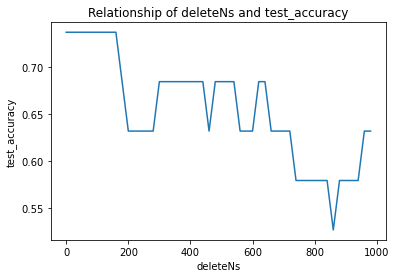

finished


In [34]:
print ("start")

## 文本预处理
folder_path = './Database/SogouC/Sample'


all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = text_processing(folder_path, test_size=0.2)

# 生成stopwords_set
stopwords_file = './stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file)

## 文本特征提取和分类
# flag = 'nltk'
flag = 'sklearn'
deleteNs = range(0, 1000, 20)
test_accuracy_list = []
for deleteN in deleteNs:
    # feature_words = words_dict(all_words_list, deleteN)
    feature_words = words_dict(all_words_list, deleteN, stopwords_set)
    train_feature_list, test_feature_list = text_features(train_data_list, test_data_list, feature_words, flag)
    test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag)
    test_accuracy_list.append(test_accuracy)
print (test_accuracy_list)

# 结果评价
#plt.figure()
plt.plot(deleteNs, test_accuracy_list)
plt.title('Relationship of deleteNs and test_accuracy')
plt.xlabel('deleteNs')
plt.ylabel('test_accuracy')
plt.show()
#plt.savefig('result.png')

print ("finished")